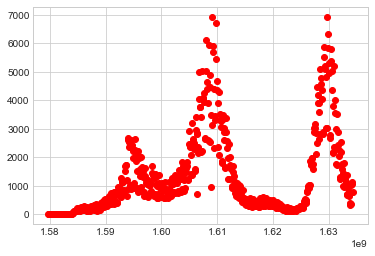

In [1]:
import numpy as np
import csv
import time
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def readTrendDataFromCSV(file):
    # Read CSV and delete label rows/columns
    reader = csv.reader(open(file))
    data = list(reader)
    del data[0:3]
    data = np.array(data)
    data = np.delete(data, 0, 1)

    # Convert string dates to Unix timestamps for easy plotting
    for entry in data:
        eDateTime = datetime.strptime(entry[0], '%b %d %Y')
        entry[0] = int(time.mktime(eDateTime.timetuple()))

    # Cast entire array to integer type
    return data.astype(np.float64)

# Plot loaded trend data (x is Unix timestamp, Y is new case number)
alabamaCases = readTrendDataFromCSV('data_table_for_daily_case_trends__alabama.csv')
plt.plot(alabamaCases[:, 0], alabamaCases[:, 1], 'ro')

In [2]:
# Create sets of 40 input data points and 1 output data point
# (model predicts the next case number given 40 previous case counts)
dataTimestamps = []
dataCuratedX = []
dataCuratedY = []

for index, entry in enumerate(alabamaCases):
    if index + 40 < len(alabamaCases):
        dataTimestamps.append(alabamaCases[index, 0])
        dataCuratedX.append(alabamaCases[index+1:index+41, 2])
        dataCuratedY.append(alabamaCases[index, 2])

dataCuratedX = np.array(dataCuratedX)
        
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(dataCuratedX)
# dataCuratedX = scaler.transform(dataCuratedX)
        
# Split training and test data
trainingSplitIndex = round(len(dataCuratedX) * 0.3)
dataTrainingTimestamps = dataTimestamps[trainingSplitIndex:]
dataTrainingX = np.asarray(dataCuratedX[trainingSplitIndex:])
dataTrainingY = np.asarray(dataCuratedY[trainingSplitIndex:])
dataTestTimestamps = dataTimestamps[:trainingSplitIndex]
dataTestX = np.asarray(dataCuratedX[:trainingSplitIndex])
dataTestY = np.asarray(dataCuratedY[:trainingSplitIndex])

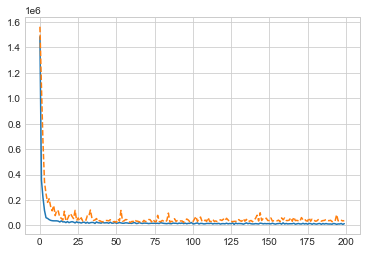

In [3]:
# Build and train model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(5, activation="relu"))
model.add(layers.Dense(1))

model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss='mean_squared_error'
)

epochs = 200

history = model.fit(dataTrainingX, dataTrainingY,
    epochs=epochs,
    validation_data=(dataTestX, dataTestY),
    verbose=0
)

# Plot loss
hLoss = history.history['loss']
hVLoss = history.history['val_loss']
plt.plot(range(epochs), hLoss, '-', range(epochs), hVLoss, '--')

Model vs training data (error)


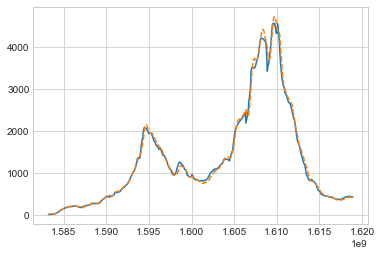

In [4]:
print('Model vs training data (error)')
dataTrainingPredY = model.predict(dataTrainingX)
plt.plot(dataTrainingTimestamps, dataTrainingY, '-', dataTrainingTimestamps, dataTrainingPredY, '--')

Model vs test data (error)


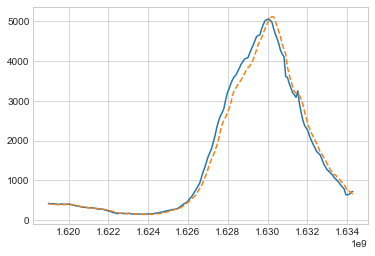

In [5]:
print('Model vs test data (error)')
dataTestPredY = model.predict(dataTestX)
plt.plot(dataTestTimestamps, dataTestY, '-', dataTestTimestamps, dataTestPredY, '--')